In [1]:
from ctypes import *
#ctypes.cdll.LoadLibrary('')
lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
from sparse_rrt.systems.acrobot import Acrobot
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd
from plan_utility.line_line_cc import *
obs_list = []
LENGTH = 20.
width = 4.
near = width * 1.2
print('generating obs...')
"""
for i in range(1):
    obs_single = []
    for j in range(4):
        '''
        The obstacle should be inside the maximal circle, but also not blocking (0,0)
        '''
        while True:
            obs = np.random.normal(size=2)
            obs = obs / np.linalg.norm(obs) * (LENGTH * 2 - LENGTH / 2)
            while True:
                # make sure it does not block (0,0)
                alpha = np.random.uniform(low=0.5, high=1.)
                obs_ = alpha * obs
                if np.abs(obs_).max() > width/2:
                    obs = obs_
                    break
            # see if it is cluttered enough by making sure obstacles can't be
            # too close
            too_near = False
            for k in range(len(obs_single)):
                if np.linalg.norm(obs-obs_single[k]) < near:
                    too_near = True
                    #print("too near")
                    break
            if not too_near:
                #print('not too near')
                break
            
        obs_single.append(obs)
    obs_single = np.array(obs_single)
    obs_list.append(obs_single)
"""
# generate one obs in each phase
for i in range(1):
    obs_single = []
    for j in range(4):
        '''
        The obstacle should be inside the maximal circle, but also not blocking (0,0)
        '''
        while True:
            obs = np.random.normal(size=2)
            obs = obs / np.linalg.norm(obs) * (LENGTH * 2 - LENGTH / 2)
            if j == 0:
                obs = np.abs(obs)  # +,+
            elif j == 1:
                obs = np.abs(obs)
                obs[0] = -obs[0]  # -,+
            elif j == 2:
                obs = np.abs(obs)
                obs[1] = -obs[1]  # +,-
            elif j== 3:
                obs = -np.abs(obs)
            while True:
                # make sure it does not block (0,0)
                alpha = np.random.uniform(low=0.8, high=1.)
                obs_ = alpha * obs
                if np.abs(obs_).max() > LENGTH/2:
                    obs = obs_
                    break
            # see if it is cluttered enough by making sure obstacles can't be
            # too close
            too_near = False
            for k in range(len(obs_single)):
                if np.linalg.norm(obs-obs_single[k]) < near:
                    too_near = True
                    #print("too near")
                    break
            if not too_near:
                #print('not too near')
                break
            
        obs_single.append(obs)
    obs_single = np.array(obs_single)
    obs_list.append(obs_single)


obs_list = np.array(obs_list)
# convert from obs to point cloud
obc_list = rectangle_pcd(obs_list, 4., 1400)
print('generated.')
print(obs_list.shape)

# obs to rectangle
obs_recs = []
for i in range(len(obs_list)):
    # for each obs setting
    obs_rec = []
    for j in range(len(obs_list[i])):
        obs_rec.append([[obs_list[i][j][0]-width/2,obs_list[i][j][1]-width/2],
                        [obs_list[i][j][0]-width/2,obs_list[i][j][1]+width/2],
                        [obs_list[i][j][0]+width/2,obs_list[i][j][1]+width/2],
                        [obs_list[i][j][0]+width/2,obs_list[i][j][1]-width/2]])
    obs_recs.append(obs_rec)

# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list[0]
obs_recs = obs_recs[0]
print(obs_list)
print(obs_recs)

generating obs...
generated.
(1, 4, 2)
[[  8.56106657  24.65064431]
 [-14.15088025  21.95995866]
 [ 25.06862422 -11.56989593]
 [-23.67215187  -9.17214916]]
[[[6.5610665733400815, 22.650644308849348], [6.5610665733400815, 26.650644308849348], [10.561066573340081, 26.650644308849348], [10.561066573340081, 22.650644308849348]], [[-16.150880249663516, 19.959958657095704], [-16.150880249663516, 23.959958657095704], [-12.150880249663516, 23.959958657095704], [-12.150880249663516, 19.959958657095704]], [[23.068624218980926, -13.569895934330166], [23.068624218980926, -9.569895934330166], [27.068624218980926, -9.569895934330166], [27.068624218980926, -13.569895934330166]], [[-25.672151870871392, -11.172149159308665], [-25.672151870871392, -7.172149159308665], [-21.672151870871392, -7.172149159308665], [-21.672151870871392, -11.172149159308665]]]


In [2]:

#obs_list = np.array(obs_list)
system = standard_cpp_systems.RectangleObs(obs_list, 4., 'acrobot')
#system = standard_cpp_systems.TwoLinkAcrobot()
#system = CartPoleObs(obs_list)
# Create SST planner
min_time_steps = 5
max_time_steps = 20
integration_step = 0.02
max_iter = 300000
goal_radius=2.0
random_seed=0
sst_delta_near=1.0
sst_delta_drain=0.5
s_g_dis_threshold = LENGTH * 1.5
low = []
high = []
state_bounds = system.get_state_bounds()
for i in range(len(state_bounds)):
    low.append(state_bounds[i][0])
    high.append(state_bounds[i][1])

start = np.zeros(4)
end = np.zeros(4)
while True:
    while True:
        start[0] = np.random.uniform(low=low[0], high=high[0])
        # make sure start midpoint
        x0_start = 0.
        y0_start = 0.
        x1_start = LENGTH * np.cos(start[0] - np.pi/2)
        y1_start = LENGTH * np.sin(start[0] - np.pi/2)
        #print('x1 = %f, y1 = %f' % (x1_start, y1_start))
        # make sure (x0, y0) to (x1, y1) is collision free
        cf = True
        for i in range(len(obs_recs)):
            for j in range(4):
                if line_line_cc(x0_start, y0_start, x1_start, y1_start, obs_recs[i][j][0], obs_recs[i][j][1], 
                                obs_recs[i][(j+1)%4][0], obs_recs[i][(j+1)%4][1]):
                    cf = False
                    break
        if cf:
            break
    print('generated start point')

    while True:
        start[1] = np.random.uniform(low=low[1], high=high[1])
        # make sure start and end not in collision
        x2_start = LENGTH * np.cos(start[0] + start[1] - np.pi/2) + x1_start
        y2_start = LENGTH * np.sin(start[0] + start[1] - np.pi/2) + y1_start
        # make sure (x0, y0) to (x1, y1) is collision free
        cf = True
        for i in range(len(obs_recs)):
            for j in range(4):
                if line_line_cc(x1_start, y1_start, x2_start, y2_start, obs_recs[i][j][0], obs_recs[i][j][1], 
                                obs_recs[i][(j+1)%4][0], obs_recs[i][(j+1)%4][1]):
                    cf = False
                    break
        if cf:
            break
    # start endpoint
    while True:
        print('generated endpoint')
        while True:
            end[0] = np.random.uniform(low=low[0], high=high[0])
            # make sure start midpoint
            x0_goal = 0.
            y0_goal = 0.
            x1_goal = LENGTH * np.cos(end[0] - np.pi/2)
            y1_goal = LENGTH * np.sin(end[0] - np.pi/2)
            # make sure (x0, y0) to (x1, y1) is collision free
            cf = True
            for i in range(len(obs_recs)):
                for j in range(4):
                    if line_line_cc(x0_goal, y0_goal, x1_goal, y1_goal, obs_recs[i][j][0], obs_recs[i][j][1], 
                                    obs_recs[i][(j+1)%4][0], obs_recs[i][(j+1)%4][1]):
                        cf = False
                        break
            if cf:
                break
        # start endpoint
        while True:
            end[1] = np.random.uniform(low=low[1], high=high[1])
            # make sure start and end not in collision
            x2_goal = LENGTH * np.cos(end[0] + end[1] - np.pi/2) + x1_goal
            y2_goal = LENGTH * np.sin(end[0] + end[1] - np.pi/2) + y1_goal
            # make sure (x0, y0) to (x1, y1) is collision free
            cf = True
            for i in range(len(obs_recs)):
                for j in range(4):
                    if line_line_cc(x1_goal, y1_goal, x2_goal, y2_goal, obs_recs[i][j][0], obs_recs[i][j][1], 
                                    obs_recs[i][(j+1)%4][0], obs_recs[i][(j+1)%4][1]):
                        cf = False
                        break
            # add endpoint length constraint
            if cf and np.linalg.norm(np.array([x2_goal,y2_goal])-np.array([x2_start,y2_start])) >= s_g_dis_threshold:
                break
        # need to be in different phase, i.e. at least one sign need to be different
        start_sign = np.array([x2_start, y2_start]) >= 0
        end_sign = np.array([x2_goal, y2_goal]) >= 0
        if start_sign[0] != end_sign[0] or start_sign[1] != end_sign[1]:
            break
    

    start[2] = 0.
    start[3] = 0.
    end[2] = 0.
    end[3] = 0.
    print('start:')
    print(start)
    print('goal:')
    print(end)
    planner = SST(
        state_bounds=system.get_state_bounds(),
        control_bounds=system.get_control_bounds(),
        distance=system.distance_computer(),
        start_state=start,
        goal_state=end,
        goal_radius=goal_radius,
        random_seed=0,
        sst_delta_near=sst_delta_near,
        sst_delta_drain=sst_delta_drain
    )


    # Run planning and print out solution is some statistics every few iterations.
    time0 = time.time()
    for iteration in range(max_iter):
        #if iteration % 50 == 0:
        #    # from time to time use the goal
        #    sample = end
        #    planner.step_with_sample(system, sample, 20, 200, 0.002)
        #else:
        planner.step(system, min_time_steps, max_time_steps, integration_step)
        #    #sample = np.random.uniform(low=low, high=high)
        #print('iteration: %d' % (iteration))
        # interation: 0.002
        #planner.step_with_sample(system, sample, 2, 20, 0.01)
        if planner.get_solution() is not None:
            break
        #if iteration % 100 == 0:
    solution = planner.get_solution()
    print("Solution: %s, Number of nodes: %s" % (planner.get_solution(), planner.get_number_of_nodes()))

    print('time spent: %f' % (time.time() - time0))
    if solution is not None:
        break

generated start point
generated endpoint
start:
[ 1.01588336 -2.36089024  0.          0.        ]
goal:
[-1.08963115 -1.10433322  0.          0.        ]
Solution: (array([[ 1.01588336, -2.36089024,  0.        ,  0.        ],
       [ 0.90653999, -2.26876406, -1.18261792,  1.01703231],
       [ 0.6917839 , -2.06622705, -1.95463775,  2.01401391],
       [-0.25088074, -0.71317009, -3.89143814,  6.        ],
       [-0.99218128,  0.46587282, -3.06132008,  5.27348756],
       [-1.34489019,  1.1344119 , -0.23720664,  1.2035884 ],
       [-1.09365225,  1.17462561,  2.17321239, -1.15994247],
       [-0.26899954,  0.57295293,  3.53311799, -3.0653353 ],
       [ 0.76764708, -0.20611507,  1.35445494,  0.09575689],
       [ 0.87956   , -0.09415502,  0.04901664,  1.72781409],
       [ 0.52578055,  0.86078952, -2.45223824,  4.71409011],
       [ 0.26883989,  1.32597233, -2.70952395,  4.48423891],
       [-0.48784862,  2.39242206, -2.91244689,  3.46347168],
       [-0.76435277,  2.70970751, -2.48933

In [3]:
states, actions, costs = solution
print(states.shape)
print(actions.shape)
print('states:')
print(states)

(34, 4)
(33, 1)
states:
[[ 1.01588336 -2.36089024  0.          0.        ]
 [ 0.90653999 -2.26876406 -1.18261792  1.01703231]
 [ 0.6917839  -2.06622705 -1.95463775  2.01401391]
 [-0.25088074 -0.71317009 -3.89143814  6.        ]
 [-0.99218128  0.46587282 -3.06132008  5.27348756]
 [-1.34489019  1.1344119  -0.23720664  1.2035884 ]
 [-1.09365225  1.17462561  2.17321239 -1.15994247]
 [-0.26899954  0.57295293  3.53311799 -3.0653353 ]
 [ 0.76764708 -0.20611507  1.35445494  0.09575689]
 [ 0.87956    -0.09415502  0.04901664  1.72781409]
 [ 0.52578055  0.86078952 -2.45223824  4.71409011]
 [ 0.26883989  1.32597233 -2.70952395  4.48423891]
 [-0.48784862  2.39242206 -2.91244689  3.46347168]
 [-0.76435277  2.70970751 -2.48933306  2.73483869]
 [-1.11302656  3.0909068  -1.15173037  1.33914087]
 [-1.20094064 -3.07402949 -0.13723395  0.48836766]
 [-0.72174626  3.00651041  2.62233926 -1.51583954]
 [-0.44134303  2.83851382  3.02095366 -1.90053366]
 [ 0.36980728  2.28899377  2.31426884 -1.7209259 ]
 [ 0.72

In [4]:
# visualize the path
"""
Given a list of states, render the environment
"""
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from visual.visualizer import Visualizer



class AcrobotVisualizer(Visualizer):
    def __init__(self, system, params):
        super(AcrobotVisualizer, self).__init__(system, params)
        self.dt = 0.05

    def _state_to_xy(self, state):
        angle0 = state[0]
        angle1 = state[1]
        x0 = 0.
        y0 = 0.
        x1 = LENGTH * np.cos(angle0 - np.pi/2)
        y1 = LENGTH * np.sin(angle0 - np.pi/2)
        x2 = x1 + LENGTH * np.cos(angle0 + angle1 - np.pi/2)
        y2 = y1 + LENGTH * np.sin(angle0 + angle1 - np.pi/2)
        return x0, y0, x1, y1, x2, y2
    def _init(self):
        # clear the current ax
        ax = plt.gca()
        ax.clear()
        # add patches
        state = self.states[0]
        print('state:')
        print(state)
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(state)
        print('x1: %f, y1: %f, x2: %f, y2: %f' % (x1, y1, x2, y2))
        self.l1 = ax.plot([x0,x1,x2], [y0,y1,y2])[0]
        self.recs = []
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        self.recs.append(self.l1)
        return self.recs
    def _animate(self, i):
        ax = plt.gca()
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        state = self.states[i]
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(state)
        self.l1.set_xdata([x0,x1,x2])
        self.l1.set_ydata([y0,y1,y2])
        return self.recs


 
    def animate(self, states, actions, obstacles):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''
        # transform the waypoint states and actions into trajectory
        traj = []
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            s = states[i]
            print(s)
            action = actions[i]
            sT = states[i+1]
            # propogate until reaching next state
            while True:
                traj.append(np.array(s))
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                #print('distance:')
                #print(np.linalg.norm(s-sT))
                s = self.system.propagate(s, action, 1, self.params['integration_step'])
                if np.linalg.norm(s-sT) <= 0.1:
                    break
        traj = np.array(traj)
        print(traj)
        print("animating...")
        # animate
        self.states = traj
        self.obs = obstacles
        print(len(self.states))
        ani = animation.FuncAnimation(plt.gcf(), self._animate, range(0, len(self.states)),
                                      interval=self.dt*500, blit=True, init_func=self._init,
                                      repeat=True)
        return ani


states:
[[ 1.01588336 -2.36089024  0.          0.        ]
 [ 0.90653999 -2.26876406 -1.18261792  1.01703231]
 [ 0.6917839  -2.06622705 -1.95463775  2.01401391]
 [-0.25088074 -0.71317009 -3.89143814  6.        ]
 [-0.99218128  0.46587282 -3.06132008  5.27348756]
 [-1.34489019  1.1344119  -0.23720664  1.2035884 ]
 [-1.09365225  1.17462561  2.17321239 -1.15994247]
 [-0.26899954  0.57295293  3.53311799 -3.0653353 ]
 [ 0.76764708 -0.20611507  1.35445494  0.09575689]
 [ 0.87956    -0.09415502  0.04901664  1.72781409]
 [ 0.52578055  0.86078952 -2.45223824  4.71409011]
 [ 0.26883989  1.32597233 -2.70952395  4.48423891]
 [-0.48784862  2.39242206 -2.91244689  3.46347168]
 [-0.76435277  2.70970751 -2.48933306  2.73483869]
 [-1.11302656  3.0909068  -1.15173037  1.33914087]
 [-1.20094064 -3.07402949 -0.13723395  0.48836766]
 [-0.72174626  3.00651041  2.62233926 -1.51583954]
 [-0.44134303  2.83851382  3.02095366 -1.90053366]
 [ 0.36980728  2.28899377  2.31426884 -1.7209259 ]
 [ 0.72831938  2.017225

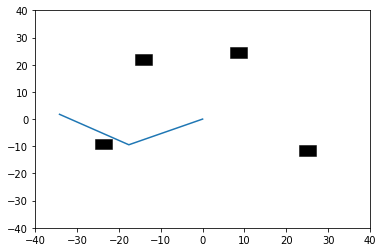

In [5]:
params = {}
params['obs_w'] = 4
params['obs_h'] = 4
params['integration_step'] = 0.02
system = Acrobot()
vis = AcrobotVisualizer(system, params)
states, actions, costs = solution
print('states:')
print(states)
anim = vis.animate(np.array(states), np.array(actions), obs_list)
HTML(anim.to_html5_video())

In [6]:
print(obs_list)

[[  8.56106657  24.65064431]
 [-14.15088025  21.95995866]
 [ 25.06862422 -11.56989593]
 [-23.67215187  -9.17214916]]
